# Laboratorium 3: transformacje cech i redukcja wymiarowości

W ramach laboratorium omówione zostaną popularne metody transformacji cech próbek oraz redukcji wymiarowości.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

boston = datasets.load_boston()
print(boston.DESCR)

digits = datasets.load_digits()

print("boston (shape): ", boston.data.shape)

#print(boston.target)

# Wycinamy kawałek danych do testów:

X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.2, random_state=421, shuffle=True)

print(X_train.shape)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## PCA

Wykonaj PCA osobno dla poszczególnych klas w zbiorze `digits`. Jaki ułamek wariancji wyjaśnia pierwsza główna składowa?

Dla cyfry 2 narysuj kilka elementów przestrzeni własnej. Czy przypominają one tą cyfrę?

Ostatni rysunek przestawia współrzędne rzutów na płaszczyznę własną rozpinaną przez dwa pierwsze wektory główne. Pokoloruj znaczniki na rysunku według normy składowej wektora prostopadłej do płaszczyzny własnej.

In [3]:
from sklearn import decomposition
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components = 10)
# dig_pca = pca.fit()
digit_no = 6
X = digits.data[digits.target == digit_no,:]

def show_digit(dgt):
  plt.figure(1, figsize=(3, 3))
  plt.imshow(dgt.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
  plt.show()

show_digit(X[1,:])
show_digit(X[10,:])

dig_pca = pca.fit(X)

print("explained variance ratio: ", dig_pca.explained_variance_ratio_[0]) # do modyfikacji

pcatr = pca.transform(digits.data)
zs = np.linalg.norm(digits.data, axis=1) # do modyfikacji

plt.figure(2, figsize = (10, 10))
other_digits = digits.target != digit_no
plt.scatter(pcatr[other_digits,0], pcatr[other_digits,1], c = zs[other_digits])

plt.scatter(pcatr[digits.target == digit_no,0], pcatr[digits.target == digit_no,1], c = zs[digits.target == digit_no], marker = 'x')
plt.colorbar()
plt.show()

<Figure size 300x300 with 1 Axes>

<Figure size 300x300 with 1 Axes>

explained variance ratio:  0.24668555416902144


<Figure size 1000x1000 with 2 Axes>

## Nieliniowa redukcja wymiarowości

UMAP zakłada, że dane leżą mniej więcej w jednej dwuwymiarowej przestrzeni. Dopasowanie polega na znalezieniu tej przestrzeni, co umożliwia potem na przykład wizualizację danych.

Porównaj metrykę _accuracy_ dla klasyfikatora SVC z kernelem RBF przed i po transformacji z użyciem UMAP za pomocą 5-krotnej walidacji krzyżowej.

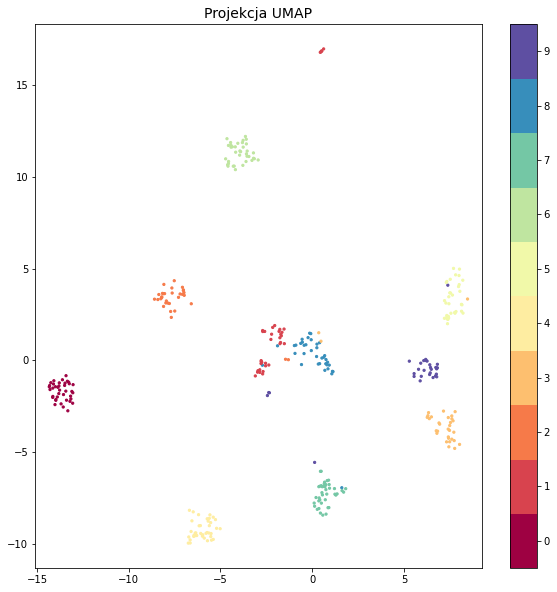

In [7]:
import umap.umap_ as umap
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn import metrics

reducer = umap.UMAP(random_state=42)

def svm_test():
  X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=421, shuffle=True)
  
  reducer.fit(X_train)

  embedding = reducer.transform(X_test)

  plt.figure(2, (10, 10))
  plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, cmap='Spectral', s=5)
  plt.gca().set_aspect('equal', 'datalim')
  plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
  plt.title('Projekcja UMAP', fontsize=14);

svm_test()

In [9]:
# Porównaj metrykę _accuracy_ dla klasyfikatora SVC z kernelem RBF
# przed i po transformacji z użyciem UMAP za pomocą 5-krotnej walidacji krzyżowej.

clf = SVC(kernel='rbf')
kf = KFold(n_splits=5, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(
digits.data, digits.target, test_size=0.2, random_state=421, shuffle=True)  

X = digits.data
y = digits.target

reducer.fit(X_train)

for train_index, test_index in kf.split(X, y):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test_origin = y[train_index], y[test_index]

  clf.fit(X_train, y_train)
  y_pred_origin = clf.predict(X_test)

#  jest potrzebne jeszcze y_test_umap
  
  reducer.fit(X_train)
  embedding = reducer.transform(X_test)
    
  y_test_umap = reducer.transform(y_test)
  y_pred_umap = clf.predict(embedding)

  print(metrics.accuracy_score(y_test_origin, y_pred_origin))
  print(metrics.accuracy_score(y_test_umap, y_pred_umap))



ValueError: Expected 2D array, got 1D array instead:
array=[2. 8. 9. 1. 0. 2. 0. 8. 6. 7. 4. 1. 3. 3. 2. 5. 4. 6. 0. 0. 0. 4. 1. 1.
 8. 6. 0. 1. 4. 1. 1. 8. 1. 2. 4. 5. 7. 8. 1. 8. 6. 9. 4. 1. 2. 3. 7. 9.
 0. 8. 4. 2. 8. 5. 7. 1. 4. 8. 5. 2. 4. 5. 9. 4. 1. 7. 4. 7. 1. 8. 2. 7.
 0. 8. 7. 0. 3. 0. 2. 8. 8. 7. 8. 4. 5. 3. 8. 2. 6. 6. 7. 7. 1. 8. 5. 1.
 0. 1. 2. 9. 5. 6. 8. 5. 0. 1. 4. 6. 8. 2. 5. 4. 4. 3. 2. 3. 7. 8. 1. 6.
 1. 4. 0. 0. 9. 1. 4. 6. 0. 1. 6. 3. 8. 3. 9. 0. 2. 8. 7. 0. 1. 5. 3. 9.
 4. 9. 7. 8. 9. 2. 4. 4. 2. 8. 3. 7. 3. 9. 4. 2. 3. 5. 0. 5. 1. 2. 2. 9.
 5. 9. 9. 3. 3. 9. 7. 4. 1. 5. 8. 2. 1. 6. 7. 7. 4. 7. 2. 6. 7. 4. 6. 8.
 5. 2. 6. 2. 7. 2. 7. 7. 9. 0. 3. 6. 2. 3. 7. 5. 7. 7. 9. 7. 3. 5. 2. 5.
 6. 1. 7. 7. 5. 2. 9. 6. 9. 7. 3. 4. 5. 8. 1. 4. 6. 0. 3. 6. 4. 8. 3. 4.
 3. 5. 3. 0. 7. 8. 5. 7. 0. 7. 6. 6. 4. 0. 2. 3. 2. 6. 8. 6. 0. 0. 8. 1.
 0. 4. 3. 0. 5. 3. 0. 9. 6. 4. 6. 8. 5. 4. 1. 9. 7. 8. 3. 3. 5. 6. 4. 7.
 6. 3. 1. 9. 1. 6. 0. 5. 8. 3. 5. 8. 0. 5. 8. 6. 6. 1. 5. 4. 7. 1. 9. 9.
 7. 5. 9. 8. 0. 4. 2. 6. 9. 0. 6. 1. 9. 0. 2. 9. 3. 0. 4. 4. 0. 2. 8. 3.
 6. 7. 3. 0. 9. 0. 5. 6. 5. 6. 1. 9. 7. 5. 0. 7. 5. 6. 4. 4. 1. 7. 0. 4.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Pipeline z selekcją cech

Zmodyfikuj poniższy pipeline tak, aby etap selekcji cech był opcjonalny. Zapoznaj się w tym celu z dokumentacją: https://scikit-learn.org/stable/modules/compose.html

Czy selekcja cech poprawia MSE?
Spróbuj z inną wybraną metodą selekcji cech.

In [6]:
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.metrics import mean_squared_error

boston = datasets.load_boston()

# Wycinamy kawałek danych do testów:

X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(
    boston.data, boston.target, test_size=0.2, random_state=421, shuffle=True)

pipe = Pipeline(steps=[
  ('feature_selection', SelectFromModel(linear_model.Lasso(alpha=0.5))),
  ('tree', tree.DecisionTreeRegressor()),
])

param_grid = {
    'tree__max_depth': [1, 2, 3, 4, None],
    'tree__min_samples_leaf': [1, 2, 4, 8]
}
search = GridSearchCV(pipe, param_grid, scoring='???')

search.fit(X_b_train, y_b_train)
print(search.best_params_)
print(search.best_score_)

print("MSE train: ", mean_squared_error(y_b_train, search.predict(X_b_train)))
print("MSE test:  ", mean_squared_error(y_b_test, search.predict(X_b_test)))

ValueError: '???' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.